<a href="https://colab.research.google.com/github/nicollcr/Nicoll_CrespoRoncallo_KC/blob/main/SEMANA7/Taller_Semana7_NicollCrespo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Taller

## Recapitulando clustering
- Crear una matriz de distancia usando criterio de enlace
    - ```method```: como calcular la proximidad de los clusters
    - ```metric```: metrica de distancia
    - ```optimal_ordering```: Orden de los puntos 
- Tipos de method
    - single: basado en los 2 objetos mas cercanos
    - complete: basado en los dos objetos mas lejanos 
    - average: basado en la media aritmetica de todos los objetos 
    - centroids: basado en la media geometrica de todos los objetos 
    - median: basado en la median de todos los objetos 
    - ward: basado en la suma de cuadrado 

# Agrupación en el conjunto de datos del vehículo

Imagine que un fabricante de automóviles ha desarrollado prototipos para un vehículo nuevo. Antes de introducir el nuevo modelo en su gama, el fabricante quiere determinar qué vehículos existentes en el mercado se parecen más a los prototipos, es decir, cómo se pueden agrupar los vehículos, qué grupo es el más similar al modelo y, por tanto, qué modelos. estarán compitiendo contra ellos.

Nuestro objetivo aquí es utilizar métodos de agrupamiento para encontrar los grupos de vehículos más distintivos. Resumirá los vehículos existentes y ayudará a la fabricación a tomar decisiones sobre nuevos modelos de forma sencilla.

### Descargar datos
Para descargar los datos, usaremos **`!wget`**. Estos datos se encuentran alojado en una API: IBM Object Storage.
__ ¿Lo sabían? __ Cuando se trata de aprendizaje automático, es probable que trabaje con grandes conjuntos de datos. Como empresa, ¿dónde puede alojar sus datos? IBM ofrece una oportunidad única para las empresas, con 10 Tb de IBM Cloud Object Storage: [Pueden registrarse aqui](http://cocl.us/ML0101EN-IBM-Offer-CC)

In [93]:
!wget -O cars_clus.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/cars_clus.csv

--2021-09-23 16:06:01--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/cars_clus.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17774 (17K) [text/csv]
Saving to: ‘cars_clus.csv’

cars_clus.csv       100%[===================>]  17.36K  --.-KB/s    in 0.01s   

2021-09-23 16:06:01 (1.43 MB/s) - ‘cars_clus.csv’ saved [17774/17774]



# Leer los datos

In [94]:
import pandas as pd
filename = 'cars_clus.csv'
#Lectura
pdf = pd.read_csv(filename)
print ("Shape: ", pdf.shape)
pdf.head(5)

Shape:  (159, 16)


,manufact,model,sales,resale,type,price,engine_s,horsepow,wheelbas,width,length,curb_wgt,fuel_cap,mpg,lnsales,partition
0,Acura,Integra,16.919,16.360,0.000,21.500,1.800,140.000,101.200,67.300,172.400,2.639,13.200,28.000,2.828,0.0
1,Acura,TL,39.384,19.875,0.000,28.400,3.200,225.000,108.100,70.300,192.900,3.517,17.200,25.000,3.673,0.0
2,Acura,CL,14.114,18.225,0.000,$null$,3.200,225.000,106.900,70.600,192.000,3.470,17.200,26.000,2.647,0.0
3,Acura,RL,8.588,29.725,0.000,42.000,3.500,210.000,114.600,71.400,196.600,3.850,18.000,22.000,2.150,0.0
4,Audi,A4,20.397,22.255,0.000,23.990,1.800,150.000,102.600,68.200,178.000,2.998,16.400,27.000,3.015,0.0


Los features incluyen:
- price en thousands (price)
- engine size (engine_s)
- horsepower (horsepow)
- wheelbase (wheelbas)
- width (width)
- length (length)
- curb weight (curb_wgt)
- fuel capacity (fuel_cap) 
- fuel efficiency (mpg).

# Data cleaning

1. Observando el proceso que se observa en el codigo de abajo que pueden concluir de que se realizo ?

In [95]:
print ("Shape antes de cleaning: ", pdf.shape)
pdf[[ 'sales', 'resale', 'type', 'price', 'engine_s',
       'horsepow', 'wheelbas', 'width', 'length', 'curb_wgt', 'fuel_cap',
       'mpg', 'lnsales']] = pdf[['sales', 'resale', 'type', 'price', 'engine_s',
       'horsepow', 'wheelbas', 'width', 'length', 'curb_wgt', 'fuel_cap',
       'mpg', 'lnsales']].apply(pd.to_numeric, errors='coerce')
pdf = pdf.dropna()
pdf = pdf.reset_index(drop=True)
print ("Shape despues de cleaning: ", pdf.shape)
pdf.head(5)

Shape antes de cleaning:  (159, 16)
Shape despues de cleaning:  (117, 16)


,manufact,model,sales,resale,type,price,engine_s,horsepow,wheelbas,width,length,curb_wgt,fuel_cap,mpg,lnsales,partition
0,Acura,Integra,16.919,16.360,0.0,21.50,1.8,140.0,101.2,67.3,172.4,2.639,13.2,28.0,2.828,0.0
1,Acura,TL,39.384,19.875,0.0,28.40,3.2,225.0,108.1,70.3,192.9,3.517,17.2,25.0,3.673,0.0
2,Acura,RL,8.588,29.725,0.0,42.00,3.5,210.0,114.6,71.4,196.6,3.850,18.0,22.0,2.150,0.0
3,Audi,A4,20.397,22.255,0.0,23.99,1.8,150.0,102.6,68.2,178.0,2.998,16.4,27.0,3.015,0.0
4,Audi,A6,18.780,23.555,0.0,33.95,2.8,200.0,108.7,76.1,192.0,3.561,18.5,22.0,2.933,0.0


**Respuesta**

R//Lo primero que se hizo fue convertir a formato númerico las columnas respectivas y al definir error como coerce, entonces los valores que no se puedan convertir seran definidos como NaN. Luego se filtra el dataframe eliminando todos los valores nulos. Debido a esto, es necesario reemplazar los indices viejos con un indice predeterminado nuevo, el drop en True hace ese reemplazo en la columna ya existente de indice y no crea una nueva. 

# Feature selection

2. Seleccionar las columnas ``engine_s,  horsepow, wheelbas, width, lenght, curb_wgt, fuel_cap y mpg`` y guardarlas en el dataset ``featureset``

In [96]:
#featureset = pdf[['engine_s','horsepow', 'wheelbas', 'width', 'length', 'curb_wgt', 'fuel_cap', 'mpg']]
featureset = pdf.loc[:, ['engine_s','horsepow', 'wheelbas', 'width', 'length', 'curb_wgt', 'fuel_cap', 'mpg']]
print(featureset.shape)
featureset.head(10)

(117, 8)


,engine_s,horsepow,wheelbas,width,length,curb_wgt,fuel_cap,mpg
0,1.8,140.0,101.2,67.3,172.4,2.639,13.2,28.0
1,3.2,225.0,108.1,70.3,192.9,3.517,17.2,25.0
2,3.5,210.0,114.6,71.4,196.6,3.850,18.0,22.0
3,1.8,150.0,102.6,68.2,178.0,2.998,16.4,27.0
4,2.8,200.0,108.7,76.1,192.0,3.561,18.5,22.0
5,4.2,310.0,113.0,74.0,198.2,3.902,23.7,21.0
6,2.8,193.0,107.3,68.5,176.0,3.197,16.6,24.0
7,2.8,193.0,111.4,70.9,188.0,3.472,18.5,24.8
8,3.1,175.0,109.0,72.7,194.6,3.368,17.5,25.0
9,3.8,240.0,109.0,72.7,196.2,3.543,17.5,23.0


# Clustering usando SCIpy

3. En esta parte usamos el paquete Scipy para agrupar el conjunto de datos:
Primero, calculamos la matriz de distancias.

Convertir a una matriz de distancias el dataset ``feature_set`` utilizando la funcion ``featureset.values`` y guardar el resultado en ``feature_mtx``



In [97]:
feature_mtx = featureset.values
feature_mtx

array([[  1.8  , 140.   , 101.2  ,  67.3  , 172.4  ,   2.639,  13.2  ,
         28.   ],
       [  3.2  , 225.   , 108.1  ,  70.3  , 192.9  ,   3.517,  17.2  ,
         25.   ],
       [  3.5  , 210.   , 114.6  ,  71.4  , 196.6  ,   3.85 ,  18.   ,
         22.   ],
       [  1.8  , 150.   , 102.6  ,  68.2  , 178.   ,   2.998,  16.4  ,
         27.   ],
       [  2.8  , 200.   , 108.7  ,  76.1  , 192.   ,   3.561,  18.5  ,
         22.   ],
       [  4.2  , 310.   , 113.   ,  74.   , 198.2  ,   3.902,  23.7  ,
         21.   ],
       [  2.8  , 193.   , 107.3  ,  68.5  , 176.   ,   3.197,  16.6  ,
         24.   ],
       [  2.8  , 193.   , 111.4  ,  70.9  , 188.   ,   3.472,  18.5  ,
         24.8  ],
       [  3.1  , 175.   , 109.   ,  72.7  , 194.6  ,   3.368,  17.5  ,
         25.   ],
       [  3.8  , 240.   , 109.   ,  72.7  , 196.2  ,   3.543,  17.5  ,
         23.   ],
       [  3.8  , 205.   , 113.8  ,  74.7  , 206.8  ,   3.778,  18.5  ,
         24.   ],
       [  3.8  , 205.

Con la matriz creada previamente ``feature_mtx`` correr el codigo de acontinuación (Esto consiste en encontrar una matriz de distancias entre individuos/automoviles). El resultado se guarda en una matriz D. 

**Nota** Si todo marcha en orden no deberia haber problemas con los siguientes dos segmentos de código

In [98]:
import scipy
from scipy.spatial import distance
leng = feature_mtx.shape[0]
D = scipy.zeros([leng,leng])
for i in range(leng):
    for j in range(leng):
        D[i,j] = scipy.spatial.distance.euclidean(feature_mtx[i], feature_mtx[j])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
  after removing the cwd from sys.path.


In [99]:
D

array([[  0.        ,  87.9180919 ,  75.79845989, ...,  16.63650252,
         28.07638866,  26.83496095],
       [ 87.9180919 ,   0.        ,  17.0877409 , ...,  75.60022934,
        115.3194773 , 114.3440861 ],
       [ 75.79845989,  17.0877409 ,   0.        , ...,  62.15304698,
        103.39586278, 102.0832197 ],
       ...,
       [ 16.63650252,  75.60022934,  62.15304698, ...,   0.        ,
         43.35044747,  41.45224917],
       [ 28.07638866, 115.3194773 , 103.39586278, ...,  43.35044747,
          0.        ,   3.75905427],
       [ 26.83496095, 114.3440861 , 102.0832197 , ...,  41.45224917,
          3.75905427,   0.        ]])

En la agrupación aglomerativa, en cada iteración, el algoritmo debe actualizar la matriz de distancia para reflejar la distancia del grupo recién formado con los grupos restantes en el bosque.

Los siguientes métodos son compatibles con Scipy para calcular la distancia entre el grupo recién formado y cada uno:

     - single
     - complete
     - average
     - weighted
     - centroid
    
4. Utilizaremos __complete__ para nuestro caso, pero en una proxima oportunidad siéntanse libres de cambiarlo para ver cómo cambian los resultados. Calcular el objeto Z por medio de la siguiente estructura de código:

``import pylab``

``import scipy.cluster.hierarchy``

``z=scipy.cluster.hierachy.linkage(D,'complete')``



In [100]:
import pylab
import scipy.cluster
Z = scipy.cluster.hierarchy.linkage(D, method='complete')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  This is separate from the ipykernel package so we can avoid doing imports until


Esencialmente, la agrupación jerárquica no requiere un número predeterminado de agrupaciones. Sin embargo, en algunas aplicaciones queremos una partición de clústeres disjuntos como en un clúster plano.

Entonces podemos usar una línea de corte:

In [101]:
from scipy.cluster.hierarchy import fcluster
max_d = 3
clusters = fcluster(Z, max_d, criterion='distance')
clusters

array([ 51, 102,  95,  59,  83,   3,  46,  47,  38,  80,  99,  97,   4,
         7,  84,  20,  30,  39,  40,  82,   9,  19,  29,  70,  31,  89,
        56,  78,  55,  71,  32, 108,  76,  41,  50,  13,  66,  22,  44,
        33,  73,  88,  90,  75,  81,  14,  77,  23,  58,  60,  87,  96,
        12,  52,  64, 104,  28,  42,  48,  94, 103,   8,   5, 106,  26,
        68,  65,  92,  72,  85,  35,  15,  16,  74,  88,  91,  37,  43,
       100,   6,   2,  17,  69, 101,  37,  34,  67,  79,  45,  49,  55,
        56,  66,  63,  36,  82,  86,  98, 107,   1,   1,  10,  11,  18,
        19,  57,  93,  53,  54,  21,  61, 105,  24,  27,  62,  25,  24],
      dtype=int32)

In [102]:
# Determinar clusters
from scipy.cluster.hierarchy import fcluster
k = 5
clusters = fcluster(Z, k, criterion='maxclust')
clusters

array([3, 4, 4, 3, 4, 1, 3, 3, 3, 4, 4, 4, 1, 1, 4, 2, 3, 3, 3, 4, 1, 2,
       2, 3, 3, 4, 3, 4, 3, 3, 3, 5, 4, 3, 3, 2, 3, 2, 3, 3, 3, 4, 4, 3,
       4, 2, 4, 2, 3, 3, 4, 4, 2, 3, 3, 4, 2, 3, 3, 4, 4, 1, 1, 4, 2, 3,
       3, 4, 3, 4, 3, 2, 2, 3, 4, 4, 3, 3, 4, 1, 1, 2, 3, 4, 3, 3, 3, 4,
       3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 1, 1, 2, 2, 2, 2, 3, 4, 3, 3, 2,
       3, 4, 2, 2, 3, 2, 2], dtype=int32)

# Dendrograma

5. Utilizar el objeto ``Z`` creado previamente en la funcion ``scipy.cluster.hierarchy.dendrogram`` para obtener el dendrograma para ello pueden utilizar de ayuda el siguiente código:
`

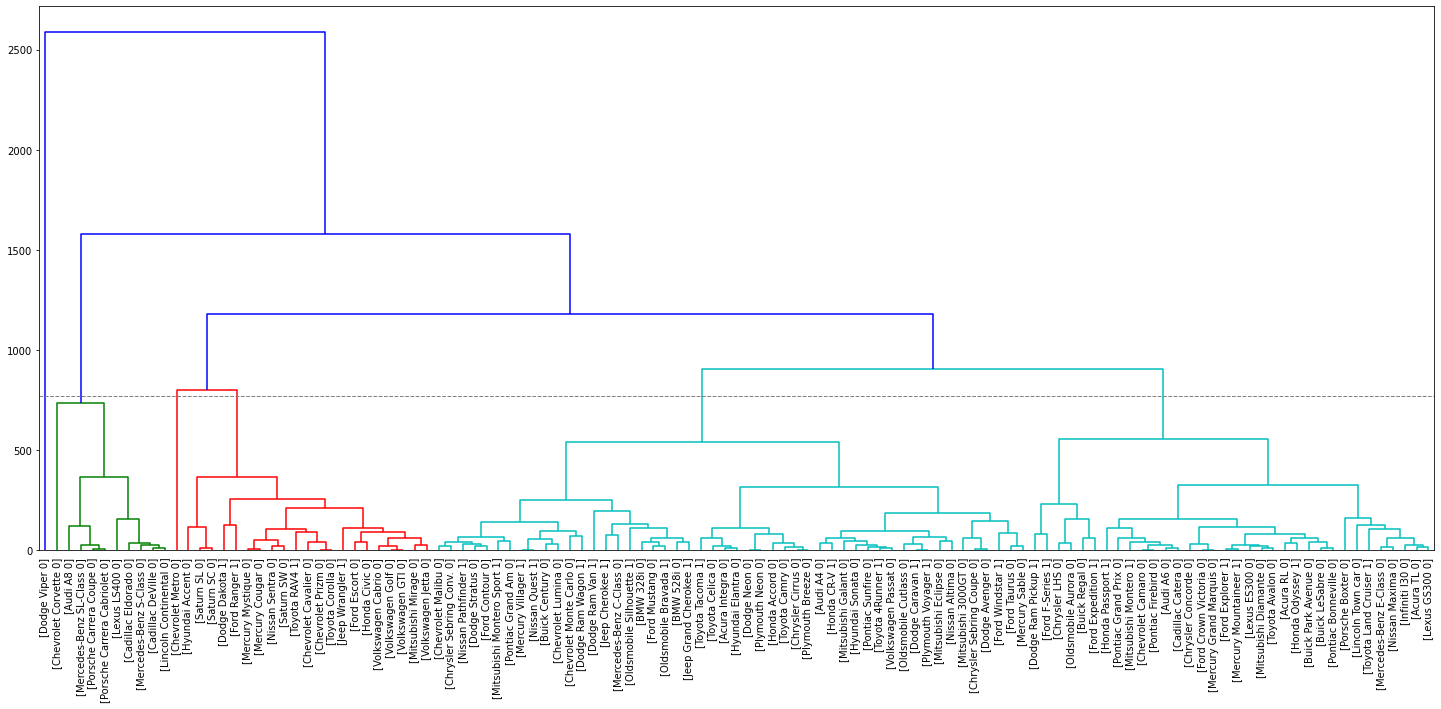

In [107]:
from scipy.cluster import hierarchy as sch

fig = pylab.figure(figsize=(25, 10))
def llf(id):
    return '[%s %s %s]' % (pdf['manufact'][id], pdf['model'][id], int(float(pdf['type'][id])) )

dendro = sch.dendrogram(Z, leaf_label_func=llf, leaf_rotation=90, leaf_font_size =10, orientation = 'top', color_threshold=1000)
plt.axhline(y=770, c='grey', lw=1, linestyle='dashed')
plt.show()

# Usando scikit learn

Ahora obtenemos la matriz de distancias usando scikit learn

In [108]:
from scipy.spatial import distance_matrix 

dist_matrix = distance_matrix(feature_mtx,feature_mtx) 
print(dist_matrix)

[[  0.          87.9180919   75.79845989 ...  16.63650252  28.07638866
   26.83496095]
 [ 87.9180919    0.          17.0877409  ...  75.60022934 115.3194773
  114.3440861 ]
 [ 75.79845989  17.0877409    0.         ...  62.15304698 103.39586278
  102.0832197 ]
 ...
 [ 16.63650252  75.60022934  62.15304698 ...   0.          43.35044747
   41.45224917]
 [ 28.07638866 115.3194773  103.39586278 ...  43.35044747   0.
    3.75905427]
 [ 26.83496095 114.3440861  102.0832197  ...  41.45224917   3.75905427
    0.        ]]


6. Utilizar el metodo ``AgglomerativeClustering`` visto en clase con ``n_clusters`` el número apropiado que consideren según en dendograma creado previamente y con propiedad ``linkage='complete'``. Guardar el modelo con el nombre``agglom``. Ajustar el modelo a los datos ``feature_mtx`` y obtener las predicciones con la funcion ``agglom.labels_``

In [109]:
from sklearn.cluster import AgglomerativeClustering
%matplotlib inline
agglom = AgglomerativeClustering(n_clusters=6, linkage='complete').fit(feature_mtx)
agglom.labels_

array([2, 0, 0, 3, 0, 1, 0, 0, 3, 0, 0, 0, 1, 1, 0, 2, 3, 3, 3, 0, 1, 2,
       4, 3, 3, 0, 2, 0, 2, 3, 3, 5, 0, 3, 0, 3, 3, 2, 0, 3, 3, 0, 0, 3,
       0, 3, 0, 2, 2, 2, 0, 0, 2, 2, 3, 0, 2, 0, 0, 0, 0, 1, 1, 0, 2, 3,
       3, 0, 3, 0, 3, 2, 2, 3, 0, 0, 3, 0, 0, 1, 1, 2, 3, 0, 3, 3, 3, 0,
       0, 0, 2, 2, 3, 3, 3, 0, 0, 0, 0, 1, 1, 2, 2, 2, 2, 2, 0, 2, 2, 2,
       3, 0, 2, 2, 3, 2, 2])

7. Crear una columna en el dataset pdf que se llame ``cluster_`` con base en los labels obtenidos con ``agglom.labels_''

In [110]:
pdf['cluster_'] = agglom.labels_
pdf

,manufact,model,sales,resale,type,price,engine_s,horsepow,wheelbas,width,length,curb_wgt,fuel_cap,mpg,lnsales,partition,cluster_
0,Acura,Integra,16.919,16.360,0.0,21.50,1.8,140.0,101.2,67.3,172.4,2.639,13.2,28.0,2.828,0.0,2
1,Acura,TL,39.384,19.875,0.0,28.40,3.2,225.0,108.1,70.3,192.9,3.517,17.2,25.0,3.673,0.0,0
2,Acura,RL,8.588,29.725,0.0,42.00,3.5,210.0,114.6,71.4,196.6,3.850,18.0,22.0,2.150,0.0,0
3,Audi,A4,20.397,22.255,0.0,23.99,1.8,150.0,102.6,68.2,178.0,2.998,16.4,27.0,3.015,0.0,3
4,Audi,A6,18.780,23.555,0.0,33.95,2.8,200.0,108.7,76.1,192.0,3.561,18.5,22.0,2.933,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,Volkswagen,Golf,9.761,11.425,0.0,14.90,2.0,115.0,98.9,68.3,163.3,2.767,14.5,26.0,2.278,0.0,2
113,Volkswagen,Jetta,83.721,13.240,0.0,16.70,2.0,115.0,98.9,68.3,172.3,2.853,14.5,26.0,4.427,0.0,2
114,Volkswagen,Passat,51.102,16.725,0.0,21.20,1.8,150.0,106.4,68.5,184.1,3.043,16.4,27.0,3.934,0.0,3
115,Volkswagen,Cabrio,9.569,16.575,0.0,19.99,2.0,115.0,97.4,66.7,160.4,3.079,13.7,26.0,2.259,0.0,2


8. Utilizar el siguiente codigo (Primero deben entenderlo) para crear una grafica de dispersion entre ``mpg`` y ``horsepow`` donde se proyecta como tercera variable el ``price``. Con base en esta grafica obtener una descripcion de cada cluster.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

Text(0, 0.5, 'mpg')

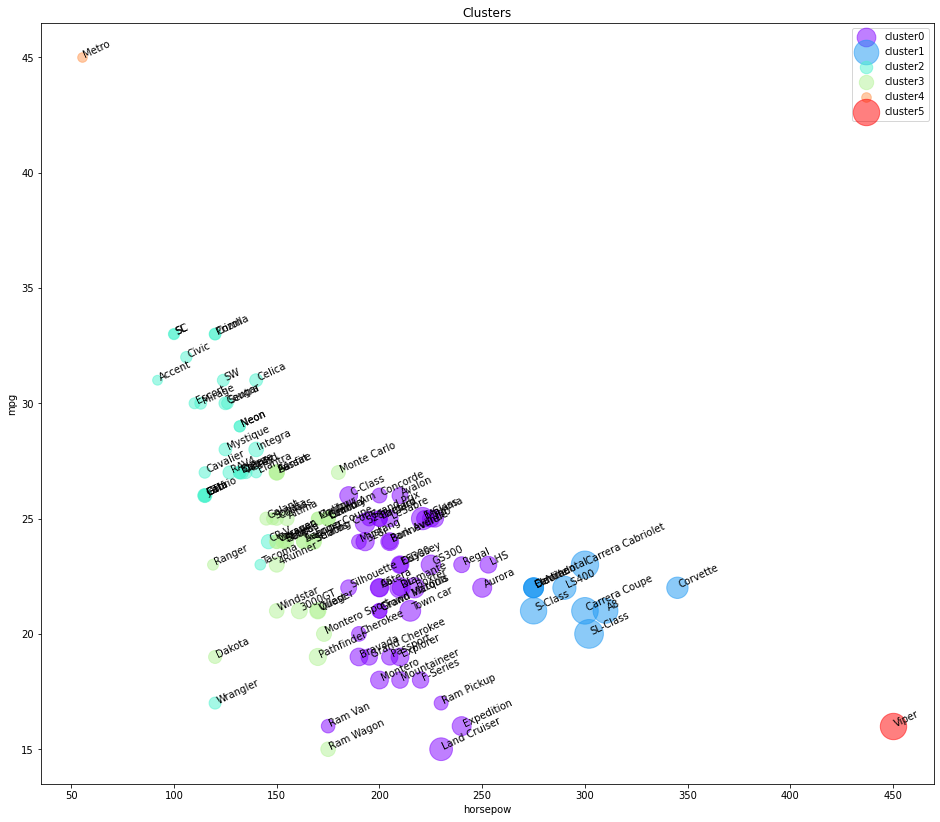

In [111]:
import matplotlib.cm as cm
import numpy as np
import matplotlib.pyplot as plt

n_clusters = max(agglom.labels_)+1
colors = cm.rainbow(np.linspace(0, 1, n_clusters))
cluster_labels = list(range(0, n_clusters))

# Figura de tamaño 16 inches por 14 inches.
plt.figure(figsize=(16,14))

for color, label in zip(colors, cluster_labels):
    subset = pdf[pdf.cluster_ == label]
    for i in subset.index:
            plt.text(subset.horsepow[i], subset.mpg[i],str(subset['model'][i]), rotation=25) 
    plt.scatter(subset.horsepow, subset.mpg, s= subset.price*10, c=color, label='cluster'+str(label),alpha=0.5)
#    plt.scatter(subset.horsepow, subset.mpg)
plt.legend()
plt.title('Clusters')
plt.xlabel('horsepow')
plt.ylabel('mpg')

**Respuesta**





1. **Cluster 5:** Representa el tipo de carros más caro, con mayor potencia, pero con muy alto consumo de combustible
2. **Cluster 1:** Representa el segundo grupo de autos más caros, los segundos con mejor potencia, pero con consumo de combustible alto
3. **Cluster 0:** Representa el grupo de autos con valores promedios de potencia y precio, pero con alto consumo de combustible
4. **Cluster 3:** Representa el grupo de autos con valores bajos de potencia y alto consumo de combustible, pero con precios bajos
5. **Cluster 2:** Representa el segundo tipo de autos más barato, con valores promedio de consumo de combustible, pero con muy baja potencia
6. **Cluster 4**: Representa el tipo de carros más barato, con el menor consumo de combustible y potencia (menos rápido)

9. Obtener un conteo para cada cluster y analizar si las estructuras son balanceadas? Porque?

In [114]:
pdf.groupby(['cluster_'])['cluster_'].count()

cluster_
0    43
1    10
2    30
3    32
4     1
5     1
Name: cluster_, dtype: int64

No son balanceadas, los cluster 4 y 5, solo tienen un tipo de auto, porque son los extremos en la gráfica uno superdeportivo de gran potencia, alto precio y alto consumo de combustible y el otro es el más barato, con la menor potencia, pero el consumo de combustible menor. Luego la mayoria de los autos se concentran en los cluster 0, 2 y 3 , sin embargo los cluster 0 y 3, son los de mayor cantidad teniendo valores entre promedio y altos de consumo de combustible, precios promedios y con potencias entre bajas y promedio. Y el cluster 1, son tambien carros costosos como el cluster 5 (en algunos casos un poco menos) y de marcas prestigiosas, pero con menor potencia y consumo de combustible. Luego el cluster 2 es la contraparte del cluster 1, siendo los segundos más baratos, los segundos con menor consumo de combustible y los segundos con menor potencia y al ser de los más baratos tambien representa un buen porcentaje de la muestra.
